In [5]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential 
from keras.layers import Dense, LSTM  # importing layers package , Dense layer is used to connect all layers
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

In [6]:
dataset5 = web.DataReader('NESTLEIND.NS', data_source='yahoo',start='2015-08-30',end='2022-10-6')
dataset5

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-08-31,6104.950195,5950.000000,6099.950195,5965.399902,69408.0,5383.920410
2015-09-01,6028.450195,5910.000000,5935.000000,6003.600098,34852.0,5418.398438
2015-09-02,6067.200195,5903.549805,6041.000000,5930.000000,40575.0,5351.972656
2015-09-03,6074.700195,5850.000000,6029.500000,6035.450195,51799.0,5447.142578
2015-09-04,6064.950195,5960.399902,6050.000000,5995.600098,19538.0,5411.178223
...,...,...,...,...,...,...
2022-09-29,19130.000000,18791.250000,18935.199219,18979.150391,87195.0,18979.150391
2022-09-30,19195.000000,18894.000000,18950.000000,19144.800781,80973.0,19144.800781
2022-10-03,19143.949219,18770.000000,19117.500000,18992.599609,52046.0,18992.599609


In [7]:
len(dataset5)

1752

In [4]:
pwd

'C:\\Users\\36kap\\Downloads'

In [8]:
dataset5.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-09-29,19130.000000,18791.250000,18935.199219,18979.150391,87195.0,18979.150391
2022-09-30,19195.000000,18894.000000,18950.000000,19144.800781,80973.0,19144.800781
2022-10-03,19143.949219,18770.000000,19117.500000,18992.599609,52046.0,18992.599609
2022-10-04,19350.000000,19051.199219,19250.000000,19251.849609,37289.0,19251.849609
2022-10-06,19525.150391,19237.250000,19342.099609,19300.150391,67036.0,19300.150391


In [9]:
opn=dataset5[['Open']]

<AxesSubplot:xlabel='Date'>

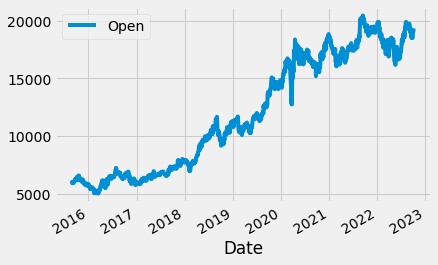

In [10]:
opn.plot()

In [11]:
ds=opn.values

In [12]:
ds

array([[ 6099.95019531],
       [ 5935.        ],
       [ 6041.        ],
       ...,
       [19117.5       ],
       [19250.        ],
       [19342.09960938]])

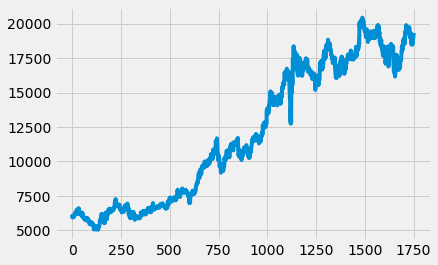

In [13]:
plt.plot(ds)

In [14]:
normalizer=MinMaxScaler(feature_range=(0,1))
ds_scaled=normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [15]:
len(ds_scaled),len(ds)

(1752, 1752)

In [16]:
train_size=int(len(ds_scaled)*0.70)
test_size=len(ds_scaled)-train_size

In [17]:
train_size,test_size

(1226, 526)

In [18]:
ds_train,ds_test=ds_scaled[0:train_size,:],ds_scaled[train_size:len(ds_scaled),:1]

In [19]:
len(ds_train),len(ds_test)

(1226, 526)

In [20]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [21]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [22]:
X_train.shape,y_train.shape

((1125, 100), (1125,))

In [23]:
X_test.shape, y_test.shape

((425, 100), (425,))

In [24]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [25]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [26]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=100)

Epoch 1/100
12/12 [==============================] - 12s 400ms/step - loss: 0.0414 - val_loss: 0.0497
Epoch 2/100
12/12 [==============================] - 3s 261ms/step - loss: 0.0070 - val_loss: 0.0057
Epoch 3/100
12/12 [==============================] - 3s 224ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 4/100
12/12 [==============================] - 3s 241ms/step - loss: 0.0014 - val_loss: 0.0042
Epoch 5/100
12/12 [==============================] - 3s 235ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 6/100
12/12 [==============================] - 3s 215ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 7/100
12/12 [==============================] - 3s 220ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 8/100
12/12 [==============================] - 3s 221ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 9/100
12/12 [==============================] - 3s 213ms/step - loss: 9.8885e-04 - val_loss: 0.0025
Epoch 10/100
12/12 [==============================] - 3s 231ms/step - loss: 9.7676e-04

Epoch 78/100
12/12 [==============================] - 3s 220ms/step - loss: 3.8238e-04 - val_loss: 5.0318e-04
Epoch 79/100
12/12 [==============================] - 3s 219ms/step - loss: 3.8129e-04 - val_loss: 5.1496e-04
Epoch 80/100
12/12 [==============================] - 3s 217ms/step - loss: 3.6299e-04 - val_loss: 7.5939e-04
Epoch 81/100
12/12 [==============================] - 3s 219ms/step - loss: 3.5421e-04 - val_loss: 4.6580e-04
Epoch 82/100
12/12 [==============================] - 3s 228ms/step - loss: 3.6456e-04 - val_loss: 5.1171e-04
Epoch 83/100
12/12 [==============================] - 3s 221ms/step - loss: 3.7454e-04 - val_loss: 5.9882e-04
Epoch 84/100
12/12 [==============================] - 3s 216ms/step - loss: 3.4996e-04 - val_loss: 7.0309e-04
Epoch 85/100
12/12 [==============================] - 3s 217ms/step - loss: 3.3594e-04 - val_loss: 0.0010
Epoch 86/100
12/12 [==============================] - 3s 219ms/step - loss: 3.5585e-04 - val_loss: 4.4610e-04
Epoch 87/100
1

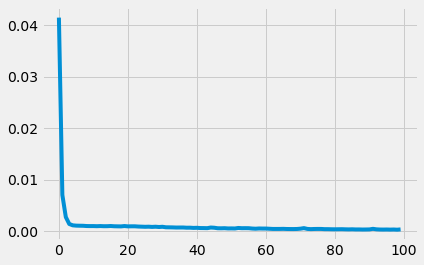

In [27]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [28]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [29]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

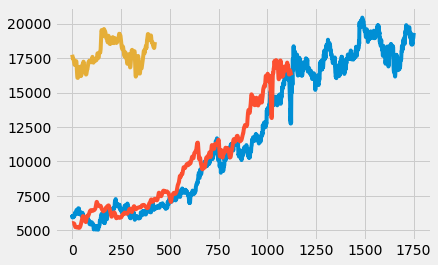

In [30]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled),label= 'Scaled Value')
plt.plot((train_predict),label= 'Training value')
plt.plot((test_predict),label= 'Testing value')

In [31]:
type(train_predict)

numpy.ndarray

In [32]:
test = np.vstack((train_predict,test_predict))

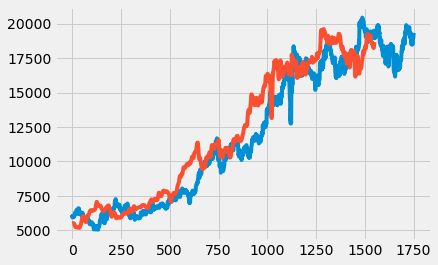

In [33]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [34]:
len(ds_test)

526

In [35]:
#Getting the last 100 days records
fut_inp = ds_test[426:]

In [36]:
fut_inp = fut_inp.reshape(1,-1)

In [37]:
tmp_inp = list(fut_inp)

In [38]:
fut_inp.shape

(1, 100)

In [39]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [40]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.9004667401313782], [0.8974015712738037], [0.8879399299621582], [0.8756287693977356], [0.8623899221420288], [0.8491970896720886], [0.8366227149963379], [0.825056791305542], [0.8147609233856201], [0.8058804869651794], [0.7984576225280762], [0.7924448847770691], [0.7877303957939148], [0.7841563820838928], [0.7815388441085815], [0.7796830534934998], [0.77839595079422], [0.7774965167045593], [0.776822030544281], [0.7762327194213867], [0.7756133675575256], [0.7748759984970093], [0.7739564776420593], [0.7728147506713867], [0.771431565284729], [0.7698044180870056], [0.7679457068443298], [0.7658786177635193], [0.7636325359344482], [0.761242151260376]]


In [41]:
len(ds_scaled)

1752

In [42]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

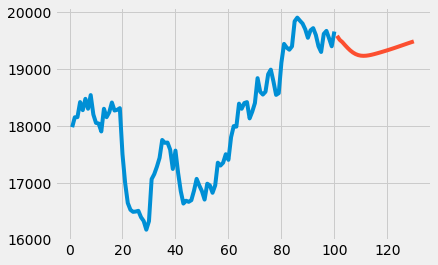

In [63]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[16:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [64]:
ds_new = ds_scaled.tolist()

In [65]:
len(ds_new)

1727

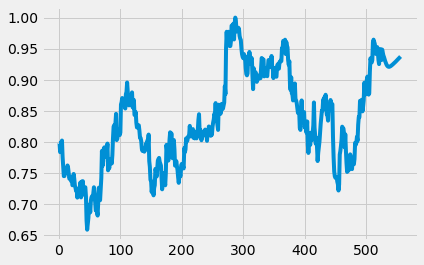

In [66]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [67]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

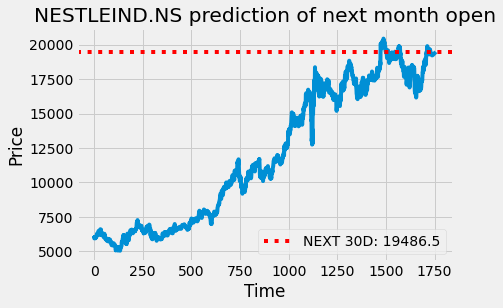

In [68]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format('NESTLEIND.NS'))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

In [69]:
final_graph

[[6099.9501953125],
 [5935.0],
 [6041.0],
 [6029.5],
 [6050.0],
 [6003.0],
 [5981.0],
 [5939.9501953125],
 [6000.0],
 [6001.0],
 [6020.0],
 [6039.9501953125],
 [6087.0],
 [6096.35009765625],
 [6255.0],
 [6220.0],
 [6178.89990234375],
 [6288.0],
 [6245.0],
 [6188.0],
 [6250.0],
 [6364.0],
 [6450.0],
 [6480.0],
 [6490.0],
 [6392.0],
 [6367.0],
 [6417.0],
 [6267.0],
 [6199.0],
 [6195.0],
 [6250.0],
 [6598.0],
 [6598.39990234375],
 [6545.0],
 [6550.0],
 [6358.0],
 [6399.0],
 [6370.0],
 [6337.5],
 [6230.0],
 [6160.0],
 [6299.0],
 [6250.0],
 [6260.0],
 [6199.0],
 [6125.0],
 [6190.0],
 [6154.7998046875],
 [6050.0],
 [6005.0],
 [6105.0],
 [6109.0],
 [6268.0],
 [6199.0],
 [6162.5],
 [6073.89990234375],
 [6021.0],
 [5900.0],
 [5858.89990234375],
 [5885.2001953125],
 [5860.0],
 [5836.0],
 [5898.0],
 [5893.0],
 [5827.10009765625],
 [5760.0],
 [5770.64990234375],
 [5909.89990234375],
 [5907.0],
 [5889.0],
 [5832.0],
 [5897.0],
 [5715.0],
 [5704.89990234375],
 [5765.0],
 [5775.0],
 [5776.0],
 [5829.

In [70]:
for i in range(0,len(final_graph)):
    print(final_graph[i])


[6099.9501953125]
[5935.0]
[6041.0]
[6029.5]
[6050.0]
[6003.0]
[5981.0]
[5939.9501953125]
[6000.0]
[6001.0]
[6020.0]
[6039.9501953125]
[6087.0]
[6096.35009765625]
[6255.0]
[6220.0]
[6178.89990234375]
[6288.0]
[6245.0]
[6188.0]
[6250.0]
[6364.0]
[6450.0]
[6480.0]
[6490.0]
[6392.0]
[6367.0]
[6417.0]
[6267.0]
[6199.0]
[6195.0]
[6250.0]
[6598.0]
[6598.39990234375]
[6545.0]
[6550.0]
[6358.0]
[6399.0]
[6370.0]
[6337.5]
[6230.0]
[6160.0]
[6299.0]
[6250.0]
[6260.0]
[6199.0]
[6125.0]
[6190.0]
[6154.7998046875]
[6050.0]
[6005.0]
[6105.0]
[6109.0]
[6268.0]
[6199.0]
[6162.5]
[6073.89990234375]
[6021.0]
[5900.0]
[5858.89990234375]
[5885.2001953125]
[5860.0]
[5836.0]
[5898.0]
[5893.0]
[5827.10009765625]
[5760.0]
[5770.64990234375]
[5909.89990234375]
[5907.0]
[5889.0]
[5832.0]
[5897.0]
[5715.0]
[5704.89990234375]
[5765.0]
[5775.0]
[5776.0]
[5829.0]
[5850.0]
[5862.64990234375]
[5820.0498046875]
[5814.0]
[5739.0]
[5666.10009765625]
[5729.9501953125]
[5690.0]
[5625.0]
[5515.0]
[5465.0]
[5460.0]
[5600.0]

[17691.05078125]
[17474.55078125]
[17530.05078125]
[17460.0]
[17525.0]
[17609.0]
[17461.400390625]
[17646.0]
[17650.19921875]
[17915.0]
[18059.0]
[17631.400390625]
[17670.0]
[17499.94921875]
[17415.05078125]
[17570.25]
[17507.05078125]
[17590.0]
[17640.0]
[17630.0]
[17679.0]
[17605.099609375]
[17635.55078125]
[17400.0]
[17616.0]
[17555.05078125]
[17755.30078125]
[17730.0]
[17691.900390625]
[17525.0]
[17655.0]
[17550.0]
[17749.94921875]
[17856.099609375]
[17930.349609375]
[18071.849609375]
[18012.0]
[18334.0]
[17950.0]
[17914.75]
[17795.80078125]
[17670.19921875]
[18294.099609375]
[18150.0]
[18200.0]
[18070.0]
[18210.0]
[18315.0]
[18180.80078125]
[18199.69921875]
[18269.55078125]
[18350.0]
[18751.0]
[18555.25]
[19700.0]
[20100.0]
[19786.0]
[19974.94921875]
[20100.0]
[20050.0]
[19745.0]
[19746.80078125]
[19874.0]
[20250.0]
[20260.150390625]
[20166.150390625]
[20300.0]
[19910.0]
[20300.0]
[20450.0]
[20369.849609375]
[20106.05078125]
[20155.0]
[20125.0]
[20200.0]
[20173.849609375]
[20000.0

In [72]:
writer=pd.ExcelWriter('Nestle_Sept.xlsx')

In [74]:
type(final_graph)

list

In [75]:
data1=pd.DataFrame({'Predictions':final_graph})

In [76]:
type(data1)

pandas.core.frame.DataFrame

In [77]:
data1

,Predictions
0,[6099.9501953125]
1,[5935.0]
2,[6041.0]
3,[6029.5]
4,[6050.0]
...,...
1752,[19423.646775484085]
1753,[19439.826286435127]
1754,[19455.799133181572]
1755,[19471.411006450653]


In [78]:
data1.to_excel(writer)

In [79]:
writer.save()